In [56]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import json
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [58]:
def setSeed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
setSeed()

In [59]:
import math
jsonTrain = "spoken_train-v1.1.json"
jsonVal = "spoken_test-v1.1.json"

file_data = pd.read_json(jsonTrain)
json_data = file_data['data']

size = math.floor(json_data.shape[0]*0.8)
trainContents = file_data['data'].loc[0:size]

file_data = pd.read_json(jsonVal)
json_data = file_data['data']

size = math.floor(json_data.shape[0]*0.5)
valContents = file_data['data'].loc[0:size]

In [60]:
def jsonLists(contents):
  texts=[]
  questions=[]
  answers=[]
  for data in contents:
    for txt in data['paragraphs']:
      text = txt['context']
      for qa in txt['qas']: 
        question = qa['question']
        for answer in qa['answers']:
          texts.append(text)
          questions.append(question)
          answers.append(answer)            
                  
  return texts,questions,answers


In [61]:
trainTexts,trainQuestions,trainAnswers=jsonLists(trainContents)
valTexts,valQuestions,valAnswers=jsonLists(valContents)

In [62]:
def addEndIndx(answers, contexts, doc_stride=150):
    for answer, context in zip(answers, contexts):
        end_idx = answer['answer_start'] + len(answer['text'])
        if context[answer['answer_start']:end_idx] == answer['text']:
            answer['answer_end'] = end_idx
        elif context[answer['answer_start'] - 1:end_idx - 1] == answer['text']:
            answer['answer_start'] = answer['answer_start'] - 1
            answer['answer_end'] = end_idx - 1
        elif context[answer['answer_start'] - 2:end_idx - 2] == answer['text']:
            answer['answer_start'] = answer['answer_start'] - 2
            answer['answer_end'] = end_idx - 2
        
        if answer.get('answer_end') and answer['answer_end'] > answer['answer_start']:
            start_idx = answer['answer_start']
            while start_idx < answer['answer_end']:
                end_idx = min(start_idx + doc_stride, len(context))
                if context[start_idx:end_idx] == answer['text']:
                    answer['answer_end'] = end_idx
                    break
                start_idx += doc_stride

In [63]:
addEndIndx(trainAnswers, trainTexts)
addEndIndx(valAnswers, valTexts)

In [64]:
from transformers import BertTokenizerFast,DistilBertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [65]:
trainEncodings=tokenizer(trainTexts,trainQuestions, truncation=True, padding=True, max_length=512,return_offsets_mapping=True)
valEncodings=tokenizer(valTexts,valQuestions, truncation=True, padding=True, max_length=512,return_offsets_mapping=True)

In [66]:
def addTokenPositions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        
        if(answers[i]['answer_end']==0):
            end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'])) 
        else:
            end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
                   
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [67]:
addTokenPositions(trainEncodings, trainAnswers)
addTokenPositions(valEncodings, valAnswers)

In [68]:
class SquadDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

In [94]:
# create datasets
trainSet = SquadDataset(trainEncodings)
valSet = SquadDataset(valEncodings)

In [ ]:
!gdown 1CQZvkPj7F7S_EcLapJKNhe8ySn63pACO

In [70]:
from transformers import BertForQuestionAnswering,DistilBertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [71]:
model.bert.config.hidden_dropout_prob = 0.1
model.bert.config.attention_probs_dropout_prob = 0.1

In [72]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8
trainDataloader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)
valDataloader = DataLoader(valSet, batch_size=batch_size, shuffle=False)

In [73]:
from transformers import get_linear_schedule_with_warmup
lr = 1e-4
epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [74]:
from accelerate import Accelerator
accelerator = Accelerator()

model, optimizer, trainDataloader, valDataloader = accelerator.prepare(model, optimizer, trainDataloader, valDataloader)

train_losses = []
val_losses = []

def train():
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        batch_losses = []

        model.train()

        for step, batch in enumerate(tqdm(trainDataloader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            with accelerator.autocast():
                outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                loss = outputs[0]

            accelerator.backward(loss)
            batch_losses.append(loss.detach().item())

            if (step + 1) % 4 == 0:
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()

        train_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(train_loss)

        with torch.no_grad():
            model.eval()
            batch_losses = []

            for batch in tqdm(valDataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                start_positions = batch['start_positions'].to(device)
                end_positions = batch['end_positions'].to(device)

                with accelerator.autocast():
                    output = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
                    loss = output[0]

                batch_losses.append(loss.detach().item())

            val_loss = sum(batch_losses) / len(batch_losses)
            val_losses.append(val_loss)

        print(f'Train loss: {train_loss:.4f}')


train()
torch.save(model.state_dict(), "model.pt")

Epoch 1/3


100%|██████████| 1117/1117 [01:30<00:00, 12.40it/s]


Train loss: 1.9304
Epoch 2/3


100%|██████████| 1117/1117 [01:29<00:00, 12.43it/s]


Train loss: 1.0196
Epoch 3/3


100%|██████████| 1117/1117 [01:29<00:00, 12.44it/s]

Train loss: 0.6512


In [75]:
# Post Processing
import jiwer

def predictTheAnswer(text,question,model):
  wer_sum = 0
  num_examples = 0
  inputs = tokenizer.encode_plus(question, text, return_tensors='pt',max_length=512, truncation=True).to(device)

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])
  answer_end = torch.argmax(outputs[1]) + 1 

  if answer_end < answer_start:
    return ""

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    
  return answer


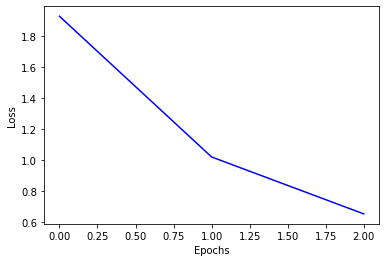

In [76]:
def lossPlot(trainLosses):
  plt.plot(trainLosses, color="b")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.show()
    
lossPlot(train_losses)

In [77]:
import jiwer

def prediction(contents, model):
    predAnswers = {}
    results = {}
    gtAnswers = {}
    questions = {}
    for data in contents['data']:
        for txt in data['paragraphs']:
            text = txt['context']
            for qa in txt['qas']:
                qid = qa['id']
                question = qa['question']
                answer = predictTheAnswer(text, question, model)
                if answer:
                    predAnswers[qid] = answer
                    questions[qid] = question
                    gtAnswers[qid] = [answer['text'] for answer in qa['answers']]

    
    wer_scores = []

    for qid in predAnswers.keys():
        if qid in gtAnswers:
            wer = jiwer.wer(' '.join(gtAnswers[qid]), ' '.join(predAnswers[qid]))
            wer_scores.append(wer)

    # Calculate the overall WER
    cumulative_wer = sum(wer_scores) / len(wer_scores)

    print(f'Cumulative WER: {cumulative_wer:.4f}')

    return predAnswers


## spoken_test-v1.1.json

In [91]:
jsonVal = "spoken_test-v1.1.json"

with open(jsonVal, 'r') as j:
    squadContents = json.loads(j.read())
predAnswers=prediction(squadContents,model)


Cumulative WER: 14.5372


## spoken_test-v1.1_WER44.json

In [92]:
jsonVal = "spoken_test-v1.1_WER44.json"
with open(jsonVal, 'r') as j:
     squadContents = json.loads(j.read())

predAnswers=prediction(squadContents,model)

Cumulative WER: 9.4124


## spoken_test-v1.1_WER54.json

In [93]:
jsonVal = "spoken_test-v1.1_WER54.json"
with open(jsonVal, 'r') as j:
     squadContents = json.loads(j.read())

predAnswers=prediction(squadContents,model)

Cumulative WER: 8.9901
